In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)



cards_to_age['head'] = cards_to_age['head'].str.strip()

# remove headers I don't want anymore
undesired_headers = ['CCH Axcess']
cards_to_age = cards_to_age.loc[~cards_to_age['head'].isin(undesired_headers), :].copy()

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
"The Simulacra, Dick",76.082289,4.004331,17.877911,19
Terraform,16.017217,8.008609,8.873454,2
Windows PATH Variable,279.415947,9.313865,68.683234,30
Node.JS and React,784.726183,25.313748,100.690102,31
"Mexican Gothic, Moreno-Garcia",1082.728772,38.668885,191.076732,28
Azure Compute Gallery,277.051202,39.578743,77.777600,7
Django,1765.753897,44.143847,221.526347,40
Azure Functions Core Tools,818.598986,48.152882,141.788841,17
Node.js and Vite,2355.772221,57.457859,258.459726,41
Python,4940.015107,63.333527,450.402157,78


# Histogram

sum of ages: ~49843.48


<Axes: >

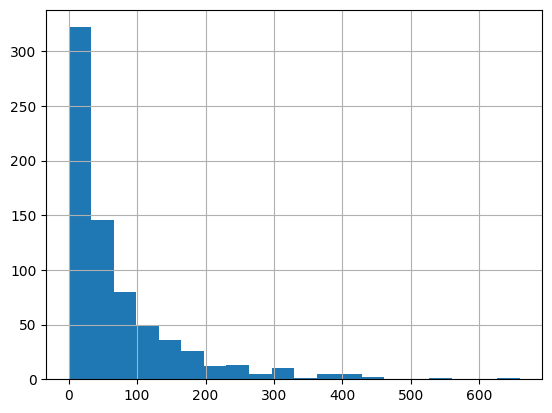

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~49843.48


<Axes: >

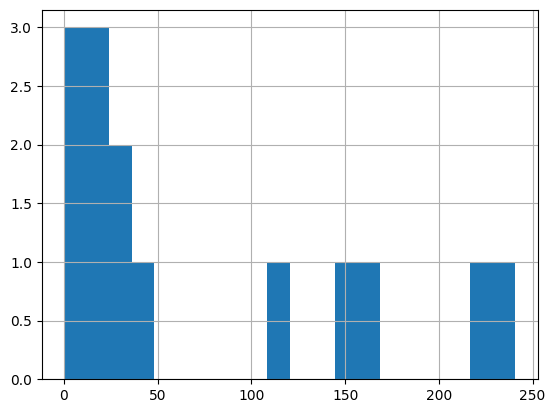

In [5]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Vocab']['age'].hist(bins=20)

# Completely Random Shuffle

In [6]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [7]:
existing_cards = existing_cards.sort_values('age', ascending=False)
remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
existing_cards.head(10)

Cards found: 715
Total card age: 49843.48


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count
155,TSQL,User-Defined Functions (UDFs):\n\nCustom funct...,db5b0e06e31ba2fcdc9d8dcb8f390532,658.731551,111.188950,658.731551,2112.590042,0.739767,19
8,pfSense,Netgate offers an automatic configuration back...,c4c4fc2311055ca400c5798ddfdf4b7a,558.033454,165.553203,558.033454,1986.638432,0.120794,12
119,Python,Q:\nHow can you check if a Path object points ...,05e2c3cee5ec04c90bef07e770b3c308,450.402157,63.333527,450.402157,4940.015107,0.745952,78
18,PnP PowerShell,Invoke-WebRequest Parameters (Microsoft.PowerS...,8464b01faa4c39ac8c219501be8b0d8b,441.991314,130.176709,441.991314,2213.004048,0.732204,17
383,Power BI,Q: Why might a table visual in Power BI show f...,c60a629e423e64fd024ee6a1560ec99d,426.018801,100.672432,426.018801,2718.155677,0.236414,27
589,Terraform Codebox,The terraform.tfvars file allows you to define...,53f7413f3c7191d894dab650181ee887,420.396139,100.061880,420.396139,4202.598963,0.089904,42
223,Terraform Codebox,Terraform custom_data for cloud-init\nA base64...,0fff0b324c270d9764802ea5dd18c942,406.307639,100.061880,420.396139,4202.598963,0.089904,42
17,PnP PowerShell,OAuth 2.0 Client Credentials Flow\nAn authenti...,c90c2d49a1ca2f62bae14c4a35f4e965,399.114105,130.176709,441.991314,2213.004048,0.732204,17
113,Azure Files Documentation,"The procedures for changing the size, cost, an...",6dbf200ea927231b69d01af54d5a79e0,397.447741,68.568588,397.447741,4114.115252,0.542817,60
41,TSQL,Common Table Expressions (CTEs):\n\nDefined wi...,522cef69fcbe464e6ab1658001074efa,392.115123,111.188950,658.731551,2112.590042,0.739767,19


# N-fold shuffle


## Age Sum

In [8]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [9]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [10]:
# n = random.choice([2, 3, 3, 4, 5, 5])

# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [11]:
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

# choices = ['floor', 'mod']
# option = random.choice(choices)
# if option == 'floor':
#     n=5
#     existing_cards['n_fold'] = existing_cards['count'] // n
#     print("floor dividing for n-fold")
# elif option == 'mod':
#     n=3
#     existing_cards['n_fold'] = existing_cards['count'] % n
#     print("modulo for n-fold")
# else: raise NotImplementedError


# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [12]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [13]:
existing_cards.head(10)['age'].sum()

np.float64(4550.558024438289)

In [14]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count
155,TSQL,User-Defined Functions (UDFs):\n\nCustom funct...,db5b0e06e31ba2fcdc9d8dcb8f390532,658.731551,111.188950,658.731551,2112.590042,0.739767,19
8,pfSense,Netgate offers an automatic configuration back...,c4c4fc2311055ca400c5798ddfdf4b7a,558.033454,165.553203,558.033454,1986.638432,0.120794,12
119,Python,Q:\nHow can you check if a Path object points ...,05e2c3cee5ec04c90bef07e770b3c308,450.402157,63.333527,450.402157,4940.015107,0.745952,78
18,PnP PowerShell,Invoke-WebRequest Parameters (Microsoft.PowerS...,8464b01faa4c39ac8c219501be8b0d8b,441.991314,130.176709,441.991314,2213.004048,0.732204,17
383,Power BI,Q: Why might a table visual in Power BI show f...,c60a629e423e64fd024ee6a1560ec99d,426.018801,100.672432,426.018801,2718.155677,0.236414,27
589,Terraform Codebox,The terraform.tfvars file allows you to define...,53f7413f3c7191d894dab650181ee887,420.396139,100.061880,420.396139,4202.598963,0.089904,42
223,Terraform Codebox,Terraform custom_data for cloud-init\nA base64...,0fff0b324c270d9764802ea5dd18c942,406.307639,100.061880,420.396139,4202.598963,0.089904,42
17,PnP PowerShell,OAuth 2.0 Client Credentials Flow\nAn authenti...,c90c2d49a1ca2f62bae14c4a35f4e965,399.114105,130.176709,441.991314,2213.004048,0.732204,17
113,Azure Files Documentation,"The procedures for changing the size, cost, an...",6dbf200ea927231b69d01af54d5a79e0,397.447741,68.568588,397.447741,4114.115252,0.542817,60
41,TSQL,Common Table Expressions (CTEs):\n\nDefined wi...,522cef69fcbe464e6ab1658001074efa,392.115123,111.188950,658.731551,2112.590042,0.739767,19


In [15]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 69.711'